In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [41]:
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Device 0: NVIDIA GeForce RTX 3070 Laptop GPU


In [42]:
DATA_PATH = Path("datasets/CMaps/")
TRAIN_FILE = DATA_PATH / "train_FD001.txt"
TEST_FILE = DATA_PATH / "test_FD001.txt"
RUL_FILE = Path(DATA_PATH / "RUL_FD001.txt")

In [43]:
def load_dataset(path):
    col_names = ["unit", "time", "os1", "os2", "os3"] + [f"s_{i}" for i in range(1, 22)]
    return pd.read_csv(path, sep=" ", header=None, names=col_names, usecols=range(26))

train_df = load_dataset(TRAIN_FILE)
test_df = load_dataset(TEST_FILE)
rul_truth = pd.read_csv(RUL_FILE, header=None)[0]


In [44]:
def add_rul(df):
    max_cycle = df.groupby("unit")["time"].max().reset_index()
    max_cycle.columns = ["unit", "max"]
    df = df.merge(max_cycle, on="unit", how="left")
    df["RUL"] = df["max"] - df["time"]
    df.drop(columns=["max"], inplace=True)
    return df

In [45]:
train_df = add_rul(train_df)
train_df.head()
drop_cols = ["unit", "time", "s_1", "s_5", "s_6", "s_10", "s_16", "s_18", "s_19"]
train_df = train_df.drop(columns=drop_cols)

# Normalize sensor data
feature_cols = [col for col in train_df.columns if col != "RUL"]
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

# Use last cycle from test data as input
test_last = test_df.groupby("unit").last().reset_index()
test_last[feature_cols] = scaler.transform(test_last[feature_cols])
test_last["RUL"] = rul_truth


In [46]:
class EngineDataset(Dataset):
    def __init__(self, df):
        self.X = df[feature_cols].values.astype(np.float32)
        self.y = df["RUL"].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EngineDataset(train_df)
test_dataset = EngineDataset(test_last)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True,num_workers=15)
test_loader = DataLoader(test_dataset, batch_size=1,pin_memory=True,num_workers=15)


In [ ]:
class RULANN(nn.Module):
    def __init__(self, input_dim):
        super(RULANN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RULANN(input_dim=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
EPOCHS = 300
patience = 100
best_loss = float('inf')
trigger_times = 0

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # --- Early Stopping Logic ---
    if epoch_loss < best_loss - 1e-4:  # small threshold to prevent tiny fluctuations
        best_loss = epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"No improvement for {trigger_times} epoch(s)")
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1, Loss: 1151049.8047
Epoch 2, Loss: 458777.8042
Epoch 3, Loss: 339576.0466
Epoch 4, Loss: 240915.8840
Epoch 5, Loss: 180239.3688
Epoch 6, Loss: 166861.0962
Epoch 7, Loss: 162999.4720
Epoch 8, Loss: 160427.4536
Epoch 9, Loss: 157949.2590
Epoch 10, Loss: 156171.7943
Epoch 11, Loss: 154802.4430
Epoch 12, Loss: 153502.8872
Epoch 13, Loss: 152279.9232
Epoch 14, Loss: 151532.0812
Epoch 15, Loss: 150597.4240
Epoch 16, Loss: 150046.9786
Epoch 17, Loss: 149514.3179
Epoch 18, Loss: 148921.0820
Epoch 19, Loss: 148408.0828
Epoch 20, Loss: 147954.5200
Epoch 21, Loss: 147917.1288
Epoch 22, Loss: 147742.8802
Epoch 23, Loss: 147240.7880
Epoch 24, Loss: 146586.3593
Epoch 25, Loss: 146729.5217
No improvement for 1 epoch(s)
Epoch 26, Loss: 146356.7648
Epoch 27, Loss: 146524.6466
No improvement for 1 epoch(s)
Epoch 28, Loss: 145811.0186
Epoch 29, Loss: 145737.8798
Epoch 30, Loss: 145690.1228
Epoch 31, Loss: 145954.7706
No improvement for 1 epoch(s)
Epoch 32, Loss: 145199.0665
Epoch 33, Loss: 145014

In [49]:
model.eval()
preds, targets = [], []
with torch.no_grad():
    for inputs, target in test_loader:
        inputs, target = inputs.to(device), target.to(device)
        pred = model(inputs)
        preds.append(pred.item())
        targets.append(target.item())

mae = mean_absolute_error(targets, preds)
rmse = np.sqrt(mean_squared_error(targets, preds))
r2 = r2_score(targets, preds)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

MAE:  24.66
RMSE: 33.14
R²:   0.3639


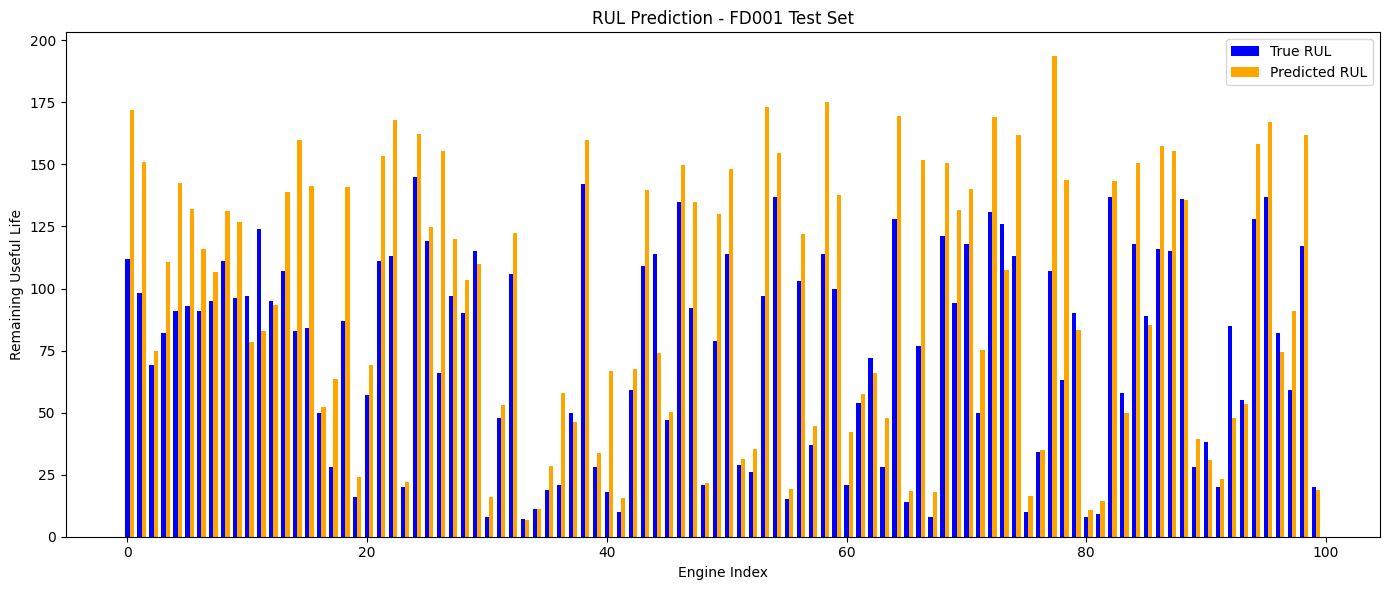

In [50]:
plt.figure(figsize=(14, 6))
indices = np.arange(len(targets))

bar_width = 0.35
plt.bar(indices, targets, bar_width, label="True RUL", color='blue')
plt.bar(indices + bar_width, preds, bar_width, label="Predicted RUL", color='orange')

plt.xlabel("Engine Index")
plt.ylabel("Remaining Useful Life")
plt.title("RUL Prediction - FD001 Test Set")
plt.legend()
plt.tight_layout()
plt.show()